Loadshed_log values clipped at: 7.41
Adjusted train/test split7467
Number of non-zero loadshed events in y_reg_seq: 4652
Number of non-zero loadshed events in y_reg_train: 3722
Number of non-zero loadshed events in y_reg_test: 930
Calculated class weights: {0: np.float64(0.9969292389853137), 1: np.float64(1.0030897367006986)}
Epoch 1/100
210/210 - 12s - 55ms/step - accuracy: 0.7679 - loss: 0.4719 - val_accuracy: 0.6774 - val_loss: 0.6468
Epoch 2/100
210/210 - 9s - 41ms/step - accuracy: 0.7975 - loss: 0.4198 - val_accuracy: 0.7242 - val_loss: 0.5502
Epoch 3/100
210/210 - 10s - 47ms/step - accuracy: 0.8098 - loss: 0.4010 - val_accuracy: 0.7323 - val_loss: 0.5097
Epoch 4/100
210/210 - 8s - 39ms/step - accuracy: 0.8190 - loss: 0.3818 - val_accuracy: 0.7323 - val_loss: 0.5350
Epoch 5/100
210/210 - 11s - 50ms/step - accuracy: 0.8284 - loss: 0.3791 - val_accuracy: 0.6586 - val_loss: 0.6588
Epoch 6/100
210/210 - 8s - 40ms/step - accuracy: 0.8315 - loss: 0.3708 - val_accuracy: 0.6948 - val_loss

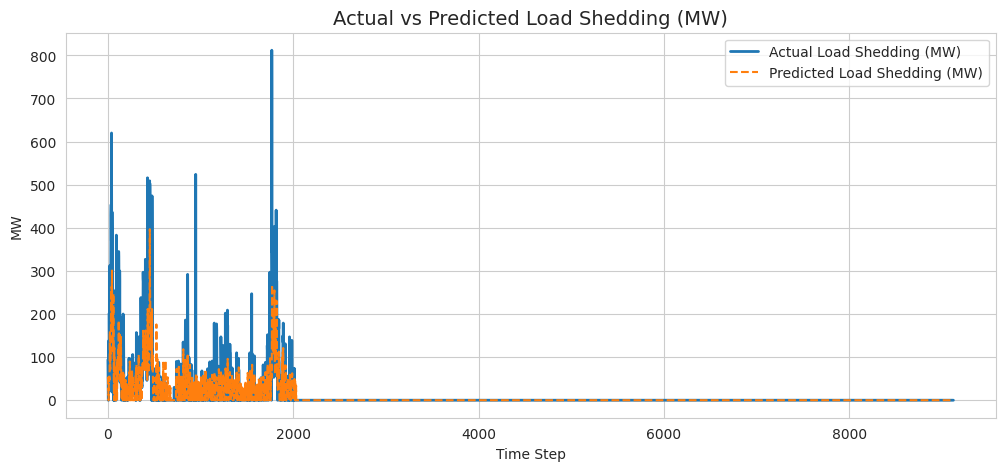

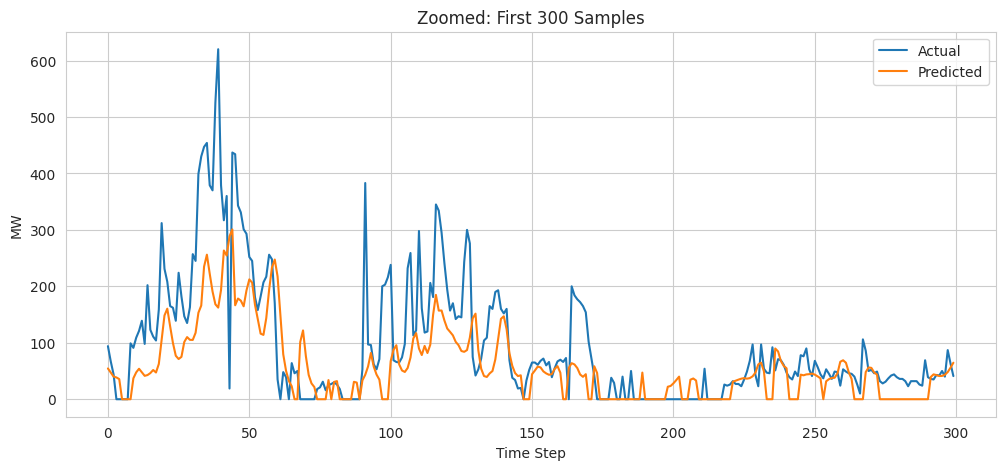

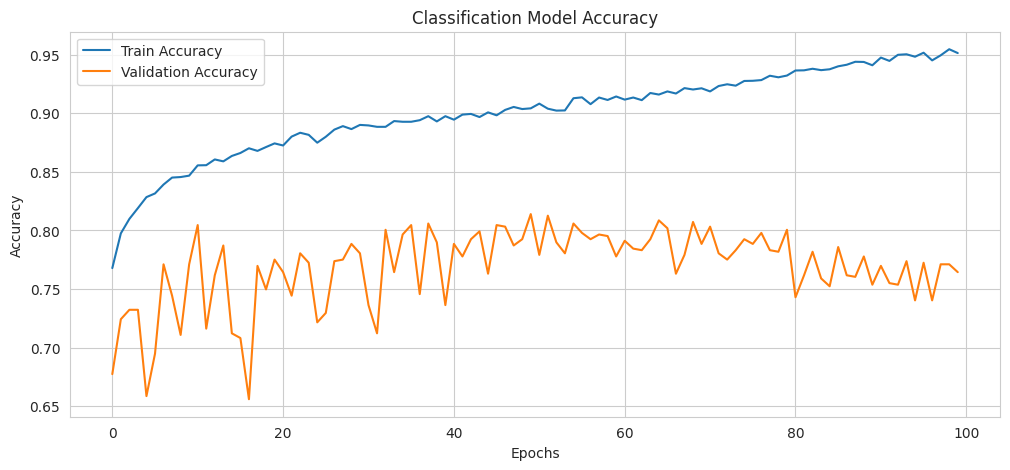

<Figure size 1200x500 with 0 Axes>

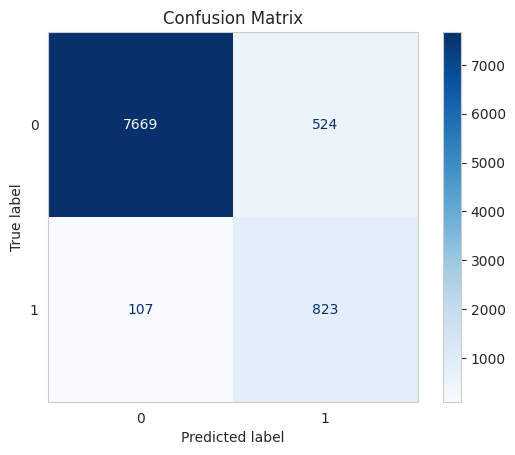

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Load & preprocess
df = pd.read_csv("/content/ThesisDataset.csv")
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Impute NaNs; don't propagate NaNs unnecessarily
original_cols_to_impute = ['Generation(MW)','Demand(MW)','Temperature(2M)','Humidity(2M)','Wind Speed(10M)']
for col in original_cols_to_impute:
    # Use ffill then bfill for robustness in time series imputation
    df[col] = df[col].ffill().bfill()

# Handle NaNs in Loadshed for lagged and log features
df['Loadshed'] = df['Loadshed'].fillna(0)

df['Diff'] = df['Demand(MW)'] - df['Generation(MW)']

df['Loadshed_lag1'] = df['Loadshed'].shift(1).fillna(0)
df['Loadshed_lag3'] = df['Loadshed'].shift(3).fillna(0)
df['Loadshed_lag6'] = df['Loadshed'].shift(6).fillna(0)

# Rolling features
for col in ['Generation(MW)', 'Demand(MW)', 'Diff']:
    df[f'{col}_roll3'] = df[col].rolling(3).mean().ffill().bfill()
    df[f'{col}_roll6'] = df[col].rolling(6).mean().ffill().bfill()

features = ['Generation(MW)','Demand(MW)','Temperature(2M)','Diff',
            'Loadshed_lag1','Loadshed_lag3','Loadshed_lag6',
            'Generation(MW)_roll3','Generation(MW)_roll6',
            'Demand(MW)_roll3','Demand(MW)_roll6',
            'Diff_roll3','Diff_roll6']

# Targets
df['Class'] = (df['Loadshed'] > 0).astype(int)
df['Loadshed_log'] = np.log1p(df['Loadshed'])

log_loadshed_non_zero = df['Loadshed_log'][df['Loadshed_log'] > 0]
if not log_loadshed_non_zero.empty:
    upper_bound_log = log_loadshed_non_zero.quantile(0.99)
    df['Loadshed_log'] = df['Loadshed_log'].clip(upper=upper_bound_log)
    print(f"Loadshed_log values clipped at: {upper_bound_log:.2f}")
else:
    print("No non-zero Loadshed_log values to clip.")

all_model_cols = features + ['Class', 'Loadshed_log']

df_processed = df[all_model_cols].dropna()

if df_processed.empty:
    raise ValueError("df_processed became empty after dropping NaNs. ")

scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df_processed[features])

# Sequence creation
TIME_STEPS = 24
def create_sequences(X, y_class, y_reg):
    X_seq, y_class_seq, y_reg_seq = [], [], []
    if len(X) <= TIME_STEPS:
        raise ValueError(f"Not enough data to create sequences with TIME_STEPS={TIME_STEPS}. Need more than {TIME_STEPS} samples.")
    for i in range(len(X) - TIME_STEPS):
        X_seq.append(X[i:i+TIME_STEPS])
        y_class_seq.append(y_class[i+TIME_STEPS])
        y_reg_seq.append(y_reg[i+TIME_STEPS])
    return np.array(X_seq), np.array(y_class_seq), np.array(y_reg_seq)

X_seq, y_class_seq, y_reg_seq = create_sequences(X, df_processed['Class'].values, df_processed['Loadshed_log'].values)

if len(X_seq) == 0:
    raise ValueError("No sequences were created.")

non_zero_loadshed_seq_indices = np.where(y_reg_seq > 0)[0]

# 80% train, 20% test
default_split_idx = int(0.8 * len(X_seq))
split = default_split_idx

if len(non_zero_loadshed_seq_indices) > 0:
    num_non_zero_in_test_target = max(1, int(0.2 * len(non_zero_loadshed_seq_indices)))

    idx_to_ensure_nz_in_test = non_zero_loadshed_seq_indices[len(non_zero_loadshed_seq_indices) - num_non_zero_in_test_target]
    split = min(default_split_idx, idx_to_ensure_nz_in_test)
    if split < TIME_STEPS:
        split = TIME_STEPS
        print("Adjusted split point made training set too small.")
    elif split >= len(X_seq) - 1:
        split = len(X_seq) - 1
        print("Adjusted split point made test set too small.")

    print(f"Adjusted train/test split{split}")
else:
    print("No non-zero loadshed events found.")

if split <= 0 or split >= len(X_seq):
    raise ValueError("Adjust data size or split ratio.")

X_train, X_test = X_seq[:split], X_seq[split:]
y_class_train, y_class_test = y_class_seq[:split], y_class_seq[split:]
y_reg_train, y_reg_test = y_reg_seq[:split], y_reg_seq[split:]

print(f"Number of non-zero loadshed events in y_reg_seq: {np.sum(y_reg_seq > 0)}")
print(f"Number of non-zero loadshed events in y_reg_train: {np.sum(y_reg_train > 0)}")
print(f"Number of non-zero loadshed events in y_reg_test: {np.sum(y_reg_test > 0)}")

# Calculate class weights for classification model
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_class_train),
    y=y_class_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Calculated class weights: {class_weight_dict}")


# Classification model
if X_train.shape[0] == 0:
    raise ValueError("X_train is empty.")

input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.4)(x)
x = GRU(128)(x)
x = BatchNormalization()(x)
x = Dense(32)(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x) # Reduced dropout for dense layer
output_class = Dense(1, activation='sigmoid')(x)

clf_model = Model(inputs=input_layer, outputs=output_class)
clf_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
clf_model.fit(X_train, y_class_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2, class_weight=class_weight_dict) # Increased epochs and added class_weight

# Regression model (non-zero only)
nonzero_idx = y_class_train == 1
if not np.any(nonzero_idx):
    print("No samples with 'Loadshed' > 0 in training.")
    reg_model = None
else:
    # Build regression model
    reg_input = Input(shape=(TIME_STEPS, X_train.shape[2]))
    x_reg = LSTM(128, return_sequences=True)(reg_input)
    x_reg = Dropout(0.4)(x_reg)
    x_reg = GRU(128)(x_reg)
    x_reg = BatchNormalization()(x_reg)
    x_reg = Dense(32)(x_reg)
    x_reg = LeakyReLU(negative_slope=0.1)(x_reg)
    x_reg = Dropout(0.2)(x_reg)
    output_reg = Dense(1)(x_reg)

    reg_model = Model(inputs=reg_input, outputs=output_reg)
    reg_model.compile(optimizer=Adam(0.001), loss=Huber(delta=1.0))
    reg_model.fit(X_train[nonzero_idx], y_reg_train[nonzero_idx], epochs=120, batch_size=32, validation_split=0.1, verbose=2)

# Predictions

if X_test.shape[0] == 0:
    print("X_test is empty.")
    y_class_pred = np.array([])
    y_class_binary = np.array([])
    y_reg_pred = np.array([])
    y_reg_pred_rescaled = np.array([])
    y_pred_final = np.array([])
    y_test_rescaled = np.array([])
    success = np.array([])
    success_rate = 0.0
else:
    y_class_pred = clf_model.predict(X_test)
    y_class_binary = (y_class_pred >= 0.5).astype(int).flatten()

    if reg_model is not None:
        y_reg_pred = reg_model.predict(X_test)
        y_reg_pred_rescaled = np.expm1(y_reg_pred).flatten()
    else:
        y_reg_pred_rescaled = np.zeros_like(y_class_binary, dtype=float)

    y_pred_final = np.where(y_class_binary==0, 0, y_reg_pred_rescaled)
    y_test_rescaled = np.expm1(y_reg_test)

    if len(y_test_rescaled) > 0 and len(y_pred_final) == len(y_test_rescaled):
        success = np.abs(y_pred_final - y_test_rescaled) <= np.maximum(0.1*y_test_rescaled, 30)
        success_rate = np.mean(success) * 100
    else:
        success_rate = 0.0
        success = np.array([])

print(f"Hybrid LSTM+GRU Success Rate: {success_rate:.2f}%")

# Show results
if len(y_test_rescaled) > 0 and len(y_pred_final) == len(y_test_rescaled):
    results = pd.DataFrame({'Actual': y_test_rescaled,'Predicted': y_pred_final,'Success': success})
    print(results.head(25))
else:
    print("No results to display.")

# Calculate MAE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE = mean_absolute_error(y_test_rescaled, y_pred_final)
RMSE = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_final))
R2 = r2_score(y_test_rescaled, y_pred_final)

print("\n========== MODEL PERFORMANCE ==========")
print(f"MAE:   {MAE:.2f} MW")
print(f"RMSE:  {RMSE:.2f} MW")
print(f"R\u00b2:    {R2:.4f}")
print(f"SUCCESS RATE: {success_rate:.2f}%")
print("========================================\n")

print("\n--- Diagnostic for y_test_rescaled ---")
if len(y_test_rescaled) > 0:
    unique_values, counts = np.unique(y_test_rescaled, return_counts=True)
    print(f"Unique values in y_test_rescaled: {unique_values}")
    print(f"Counts of unique values: {counts}")
    non_zero_count = np.sum(y_test_rescaled > 0)
    print(f"Number of non-zero values in y_test_rescaled: {non_zero_count}")
    if non_zero_count == 0:
        print("All actual loadshedding values in the test set are zero.")
else:
    print("y_test_rescaled is empty.")
print("--------------------------------------")


# Plot Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label="Actual Load Shedding (MW)", linewidth=2)
plt.plot(y_pred_final, label="Predicted Load Shedding (MW)", linestyle='dashed')
plt.title("Actual vs Predicted Load Shedding (MW)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Plot Zoomed

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled[:300], label="Actual")
plt.plot(y_pred_final[:300], label="Predicted")
plt.title("Zoomed: First 300 Samples")
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


clf_history = clf_model.history

# Create Accuracy Plot
plt.figure(figsize=(12,5))
plt.plot(clf_history.history['accuracy'], label='Train Accuracy')
plt.plot(clf_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Create Confusion Matrix Plot
cm = confusion_matrix(y_class_test, y_class_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

plt.figure(figsize=(12,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

Loadshed_log values clipped at: 7.41
Adjusted train/test split7467
Number of non-zero loadshed events in y_reg_seq: 4652
Number of non-zero loadshed events in y_reg_train: 3722
Number of non-zero loadshed events in y_reg_test: 930
Calculated class weights: {0: np.float64(0.9969292389853137), 1: np.float64(1.0030897367006986)}
Epoch 1/100
210/210 - 18s - 86ms/step - accuracy: 0.7827 - loss: 0.4555 - val_accuracy: 0.6894 - val_loss: 0.5862
Epoch 2/100
210/210 - 13s - 63ms/step - accuracy: 0.8009 - loss: 0.4191 - val_accuracy: 0.7269 - val_loss: 0.5949
Epoch 3/100
210/210 - 20s - 97ms/step - accuracy: 0.8115 - loss: 0.3942 - val_accuracy: 0.7430 - val_loss: 0.5730
Epoch 4/100
210/210 - 13s - 62ms/step - accuracy: 0.8185 - loss: 0.3806 - val_accuracy: 0.7443 - val_loss: 0.5107
Epoch 5/100
210/210 - 13s - 63ms/step - accuracy: 0.8347 - loss: 0.3633 - val_accuracy: 0.4203 - val_loss: 1.0445
Epoch 6/100
210/210 - 13s - 61ms/step - accuracy: 0.8458 - loss: 0.3526 - val_accuracy: 0.6975 - val_l

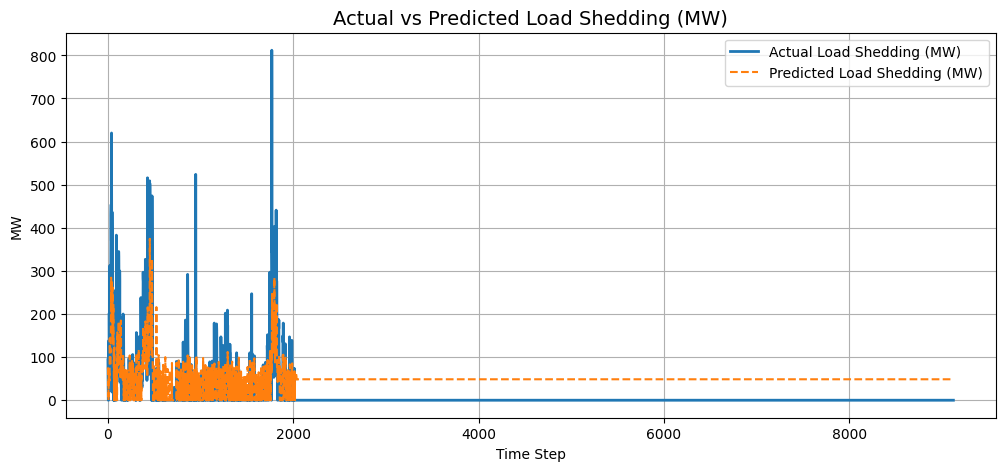

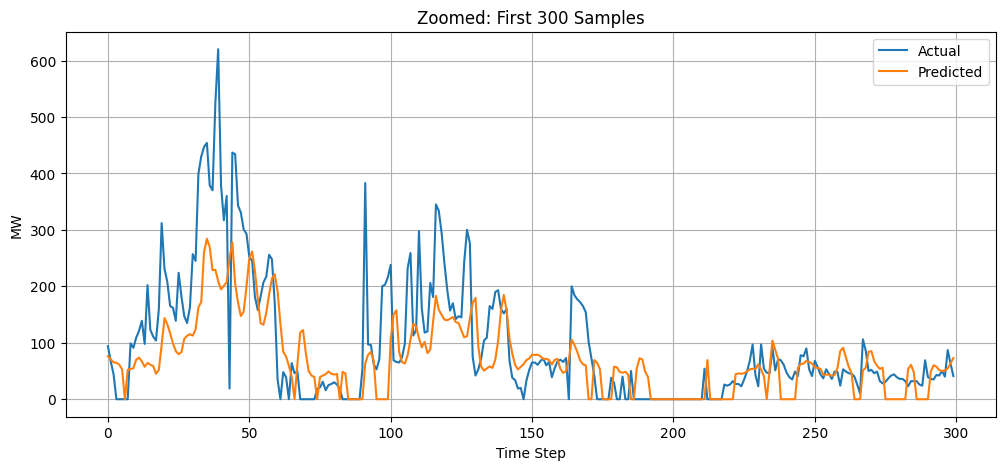

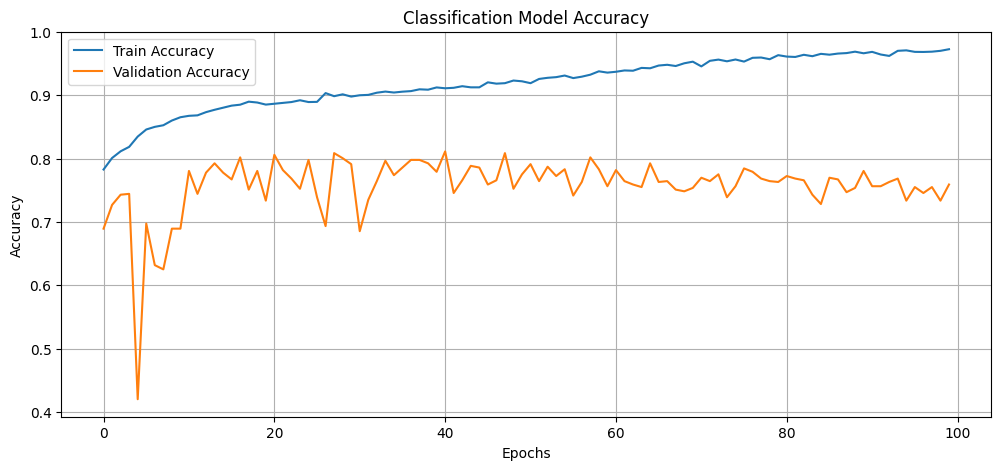

<Figure size 1200x500 with 0 Axes>

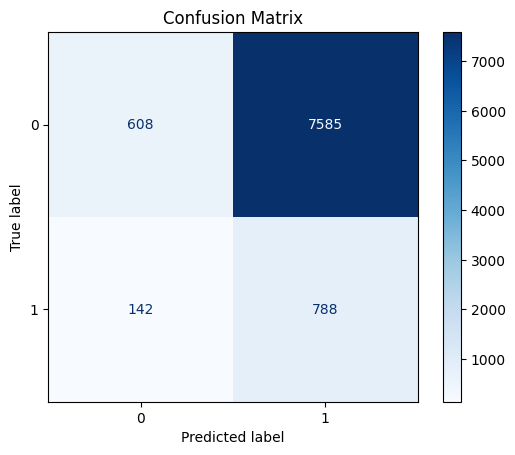

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Load & preprocess
df = pd.read_csv("/content/ThesisDataset.csv")
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Impute NaNs; don't propagate NaNs unnecessarily
original_cols_to_impute = ['Generation(MW)','Demand(MW)','Temperature(2M)','Humidity(2M)','Wind Speed(10M)']
for col in original_cols_to_impute:
    # Use ffill then bfill for robustness in time series imputation
    df[col] = df[col].ffill().bfill()

# Handle NaNs in Loadshed for lagged and log features
df['Loadshed'] = df['Loadshed'].fillna(0)

df['Diff'] = df['Demand(MW)'] - df['Generation(MW)']

df['Loadshed_lag1'] = df['Loadshed'].shift(1).fillna(0)
df['Loadshed_lag3'] = df['Loadshed'].shift(3).fillna(0)
df['Loadshed_lag6'] = df['Loadshed'].shift(6).fillna(0)

# Rolling features
for col in ['Generation(MW)', 'Demand(MW)', 'Diff']:
    df[f'{col}_roll3'] = df[col].rolling(3).mean().ffill().bfill()
    df[f'{col}_roll6'] = df[col].rolling(6).mean().ffill().bfill()

features = ['Generation(MW)','Demand(MW)','Temperature(2M)','Diff',
            'Loadshed_lag1','Loadshed_lag3','Loadshed_lag6',
            'Generation(MW)_roll3','Generation(MW)_roll6',
            'Demand(MW)_roll3','Demand(MW)_roll6',
            'Diff_roll3','Diff_roll6']

# Targets
df['Class'] = (df['Loadshed'] > 0).astype(int)
df['Loadshed_log'] = np.log1p(df['Loadshed'])

log_loadshed_non_zero = df['Loadshed_log'][df['Loadshed_log'] > 0]
if not log_loadshed_non_zero.empty:
    upper_bound_log = log_loadshed_non_zero.quantile(0.99)
    df['Loadshed_log'] = df['Loadshed_log'].clip(upper=upper_bound_log)
    print(f"Loadshed_log values clipped at: {upper_bound_log:.2f}")
else:
    print("No non-zero Loadshed_log values to clip.")

all_model_cols = features + ['Class', 'Loadshed_log']

df_processed = df[all_model_cols].dropna()

if df_processed.empty:
    raise ValueError("df_processed became empty after dropping NaNs. ")

scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df_processed[features])

# Sequence creation
TIME_STEPS = 24
def create_sequences(X, y_class, y_reg):
    X_seq, y_class_seq, y_reg_seq = [], [], []
    if len(X) <= TIME_STEPS:
        raise ValueError(f"Not enough data to create sequences with TIME_STEPS={TIME_STEPS}. Need more than {TIME_STEPS} samples.")
    for i in range(len(X) - TIME_STEPS):
        X_seq.append(X[i:i+TIME_STEPS])
        y_class_seq.append(y_class[i+TIME_STEPS])
        y_reg_seq.append(y_reg[i+TIME_STEPS])
    return np.array(X_seq), np.array(y_class_seq), np.array(y_reg_seq)

X_seq, y_class_seq, y_reg_seq = create_sequences(X, df_processed['Class'].values, df_processed['Loadshed_log'].values)

if len(X_seq) == 0:
    raise ValueError("No sequences were created.")

non_zero_loadshed_seq_indices = np.where(y_reg_seq > 0)[0]

# 80% train, 20% test
default_split_idx = int(0.8 * len(X_seq))
split = default_split_idx

if len(non_zero_loadshed_seq_indices) > 0:
    num_non_zero_in_test_target = max(1, int(0.2 * len(non_zero_loadshed_seq_indices)))

    idx_to_ensure_nz_in_test = non_zero_loadshed_seq_indices[len(non_zero_loadshed_seq_indices) - num_non_zero_in_test_target]
    split = min(default_split_idx, idx_to_ensure_nz_in_test)
    if split < TIME_STEPS:
        split = TIME_STEPS
        print("Adjusted split point made training set too small.")
    elif split >= len(X_seq) - 1:
        split = len(X_seq) - 1
        print("Adjusted split point made test set too small.")

    print(f"Adjusted train/test split{split}")
else:
    print("No non-zero loadshed events found.")

if split <= 0 or split >= len(X_seq):
    raise ValueError("Adjust data size or split ratio.")

X_train, X_test = X_seq[:split], X_seq[split:]
y_class_train, y_class_test = y_class_seq[:split], y_class_seq[split:]
y_reg_train, y_reg_test = y_reg_seq[:split], y_reg_seq[split:]

print(f"Number of non-zero loadshed events in y_reg_seq: {np.sum(y_reg_seq > 0)}")
print(f"Number of non-zero loadshed events in y_reg_train: {np.sum(y_reg_train > 0)}")
print(f"Number of non-zero loadshed events in y_reg_test: {np.sum(y_reg_test > 0)}")

# Calculate class weights for classification model
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_class_train),
    y=y_class_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Calculated class weights: {class_weight_dict}")


# Classification model
if X_train.shape[0] == 0:
    raise ValueError("X_train is empty.")

input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))
x = GRU(128, return_sequences=True)(input_layer)
x = Dropout(0.4)(x)
x = GRU(128)(x)
x = BatchNormalization()(x)
x = Dense(32)(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x) # Reduced dropout for dense layer
output_class = Dense(1, activation='sigmoid')(x)

clf_model = Model(inputs=input_layer, outputs=output_class)
clf_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
clf_model.fit(X_train, y_class_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2, class_weight=class_weight_dict) # Increased epochs and added class_weight

# Regression model (non-zero only)
nonzero_idx = y_class_train == 1
if not np.any(nonzero_idx):
    print("No samples with 'Loadshed' > 0 in training.")
    reg_model = None
else:
    # Build regression model
    reg_input = Input(shape=(TIME_STEPS, X_train.shape[2]))
    x_reg = GRU(128, return_sequences=True)(reg_input)
    x_reg = Dropout(0.4)(x_reg)
    x_reg = GRU(128)(x_reg)
    x_reg = BatchNormalization()(x_reg)
    x_reg = Dense(32)(x_reg)
    x_reg = LeakyReLU(negative_slope=0.1)(x_reg)
    x_reg = Dropout(0.2)(x_reg)
    output_reg = Dense(1)(x_reg)

    reg_model = Model(inputs=reg_input, outputs=output_reg)
    reg_model.compile(optimizer=Adam(0.001), loss=Huber(delta=1.0))
    reg_model.fit(X_train[nonzero_idx], y_reg_train[nonzero_idx], epochs=120, batch_size=32, validation_split=0.1, verbose=2)

# Predictions

if X_test.shape[0] == 0:
    print("X_test is empty.")
    y_class_pred = np.array([])
    y_class_binary = np.array([])
    y_reg_pred = np.array([])
    y_reg_pred_rescaled = np.array([])
    y_pred_final = np.array([])
    y_test_rescaled = np.array([])
    success = np.array([])
    success_rate = 0.0
else:
    y_class_pred = clf_model.predict(X_test)
    y_class_binary = (y_class_pred >= 0.5).astype(int).flatten()

    if reg_model is not None:
        y_reg_pred = reg_model.predict(X_test)
        y_reg_pred_rescaled = np.expm1(y_reg_pred).flatten()
    else:
        y_reg_pred_rescaled = np.zeros_like(y_class_binary, dtype=float)

    y_pred_final = np.where(y_class_binary==0, 0, y_reg_pred_rescaled)
    y_test_rescaled = np.expm1(y_reg_test)

    if len(y_test_rescaled) > 0 and len(y_pred_final) == len(y_test_rescaled):
        success = np.abs(y_pred_final - y_test_rescaled) <= np.maximum(0.1*y_test_rescaled, 30)
        success_rate = np.mean(success) * 100
    else:
        success_rate = 0.0
        success = np.array([])

print(f"Hybrid LSTM+GRU Success Rate: {success_rate:.2f}%")

# Show results
if len(y_test_rescaled) > 0 and len(y_pred_final) == len(y_test_rescaled):
    results = pd.DataFrame({'Actual': y_test_rescaled,'Predicted': y_pred_final,'Success': success})
    print(results.head(25))
else:
    print("No results to display.")

# Calculate MAE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE = mean_absolute_error(y_test_rescaled, y_pred_final)
RMSE = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_final))
R2 = r2_score(y_test_rescaled, y_pred_final)

print("\n========== MODEL PERFORMANCE ==========")
print(f"MAE:   {MAE:.2f} MW")
print(f"RMSE:  {RMSE:.2f} MW")
print(f"R\u00b2:    {R2:.4f}")
print(f"SUCCESS RATE: {success_rate:.2f}%")
print("========================================\n")

print("\n--- Diagnostic for y_test_rescaled ---")
if len(y_test_rescaled) > 0:
    unique_values, counts = np.unique(y_test_rescaled, return_counts=True)
    print(f"Unique values in y_test_rescaled: {unique_values}")
    print(f"Counts of unique values: {counts}")
    non_zero_count = np.sum(y_test_rescaled > 0)
    print(f"Number of non-zero values in y_test_rescaled: {non_zero_count}")
    if non_zero_count == 0:
        print("All actual loadshedding values in the test set are zero.")
else:
    print("y_test_rescaled is empty.")
print("--------------------------------------")


# Plot Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label="Actual Load Shedding (MW)", linewidth=2)
plt.plot(y_pred_final, label="Predicted Load Shedding (MW)", linestyle='dashed')
plt.title("Actual vs Predicted Load Shedding (MW)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Plot Zoomed

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled[:300], label="Actual")
plt.plot(y_pred_final[:300], label="Predicted")
plt.title("Zoomed: First 300 Samples")
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


clf_history = clf_model.history

# Create Accuracy Plot
plt.figure(figsize=(12,5))
plt.plot(clf_history.history['accuracy'], label='Train Accuracy')
plt.plot(clf_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Create Confusion Matrix Plot
cm = confusion_matrix(y_class_test, y_class_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

plt.figure(figsize=(12,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

Loadshed_log values clipped at: 7.41
Adjusted train/test split7467
Number of non-zero loadshed events in y_reg_seq: 4652
Number of non-zero loadshed events in y_reg_train: 3722
Number of non-zero loadshed events in y_reg_test: 930
Calculated class weights: {0: np.float64(0.9969292389853137), 1: np.float64(1.0030897367006986)}
Epoch 1/100
210/210 - 24s - 115ms/step - accuracy: 0.7808 - loss: 0.4578 - val_accuracy: 0.7068 - val_loss: 0.6270
Epoch 2/100
210/210 - 15s - 74ms/step - accuracy: 0.7985 - loss: 0.4154 - val_accuracy: 0.7523 - val_loss: 0.5290
Epoch 3/100
210/210 - 15s - 71ms/step - accuracy: 0.8158 - loss: 0.3919 - val_accuracy: 0.7510 - val_loss: 0.5008
Epoch 4/100
210/210 - 16s - 77ms/step - accuracy: 0.8188 - loss: 0.3882 - val_accuracy: 0.7871 - val_loss: 0.5050
Epoch 5/100
210/210 - 15s - 71ms/step - accuracy: 0.8317 - loss: 0.3669 - val_accuracy: 0.5676 - val_loss: 1.1456
Epoch 6/100
210/210 - 15s - 71ms/step - accuracy: 0.8359 - loss: 0.3501 - val_accuracy: 0.6801 - val_

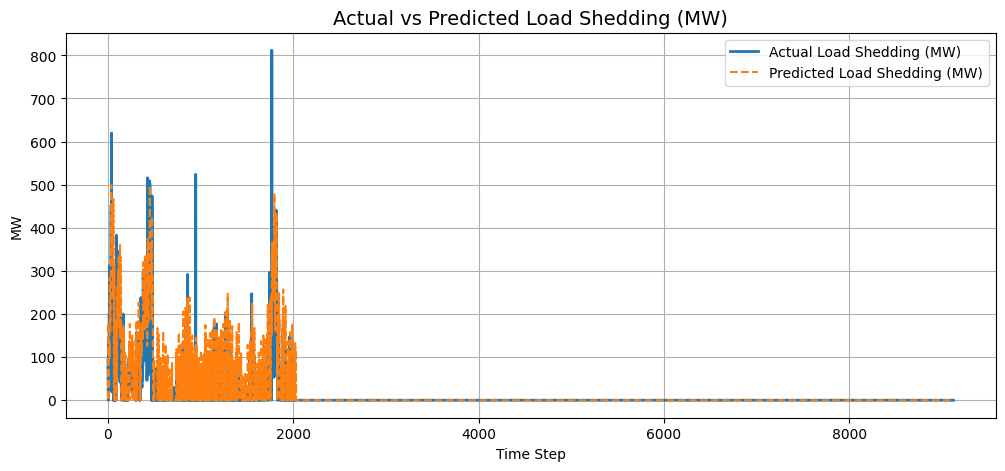

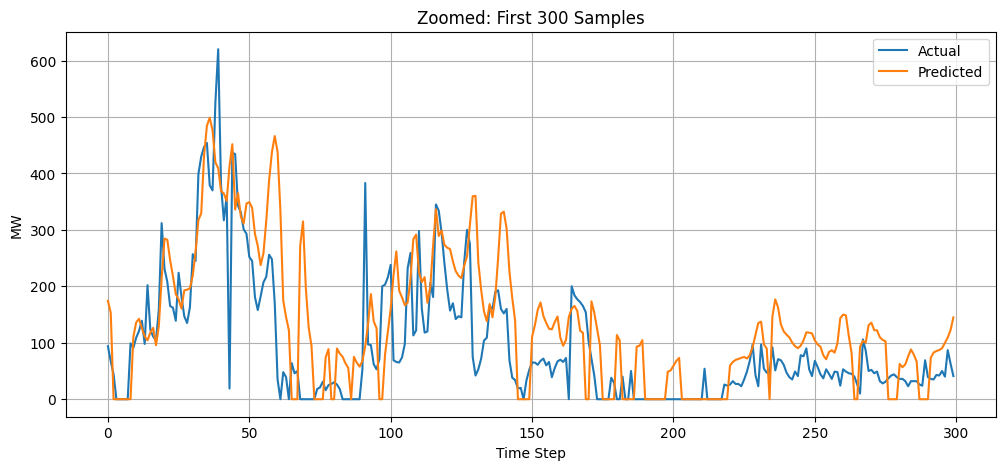

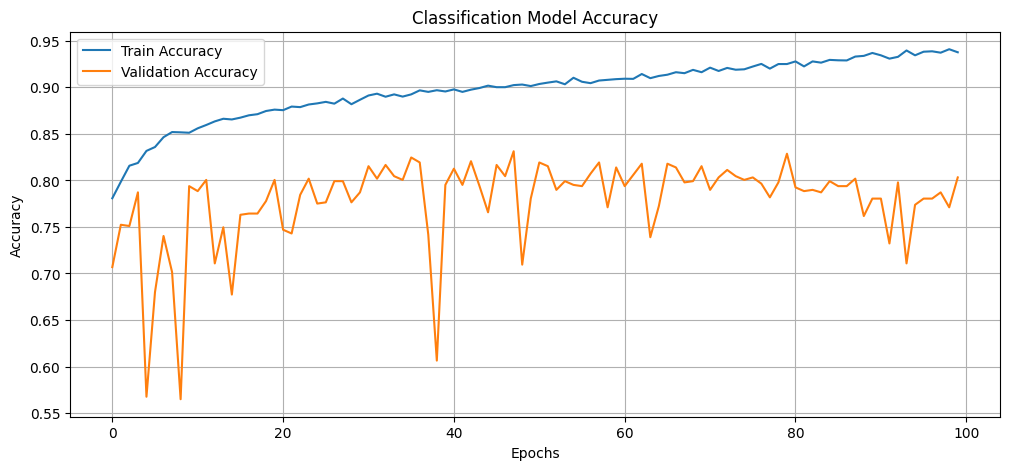

<Figure size 1200x500 with 0 Axes>

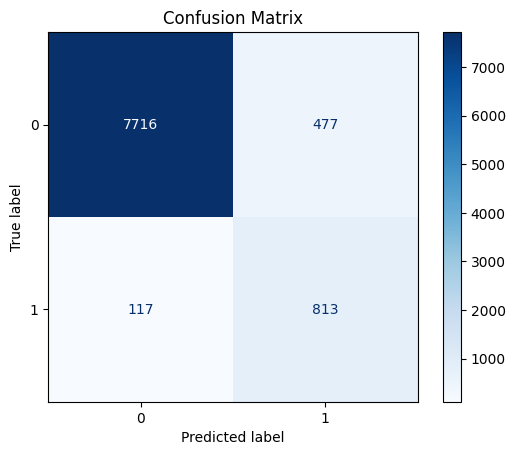

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# Load & preprocess
df = pd.read_csv("/content/ThesisDataset.csv")
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Impute NaNs; don't propagate NaNs unnecessarily
original_cols_to_impute = ['Generation(MW)','Demand(MW)','Temperature(2M)','Humidity(2M)','Wind Speed(10M)']
for col in original_cols_to_impute:
    # Use ffill then bfill for robustness in time series imputation
    df[col] = df[col].ffill().bfill()

# Handle NaNs in Loadshed for lagged and log features
df['Loadshed'] = df['Loadshed'].fillna(0)

df['Diff'] = df['Demand(MW)'] - df['Generation(MW)']

df['Loadshed_lag1'] = df['Loadshed'].shift(1).fillna(0)
df['Loadshed_lag3'] = df['Loadshed'].shift(3).fillna(0)
df['Loadshed_lag6'] = df['Loadshed'].shift(6).fillna(0)

# Rolling features
for col in ['Generation(MW)', 'Demand(MW)', 'Diff']:
    df[f'{col}_roll3'] = df[col].rolling(3).mean().ffill().bfill()
    df[f'{col}_roll6'] = df[col].rolling(6).mean().ffill().bfill()

features = ['Generation(MW)','Demand(MW)','Temperature(2M)','Diff',
            'Loadshed_lag1','Loadshed_lag3','Loadshed_lag6',
            'Generation(MW)_roll3','Generation(MW)_roll6',
            'Demand(MW)_roll3','Demand(MW)_roll6',
            'Diff_roll3','Diff_roll6']

# Targets
df['Class'] = (df['Loadshed'] > 0).astype(int)
df['Loadshed_log'] = np.log1p(df['Loadshed'])

log_loadshed_non_zero = df['Loadshed_log'][df['Loadshed_log'] > 0]
if not log_loadshed_non_zero.empty:
    upper_bound_log = log_loadshed_non_zero.quantile(0.99)
    df['Loadshed_log'] = df['Loadshed_log'].clip(upper=upper_bound_log)
    print(f"Loadshed_log values clipped at: {upper_bound_log:.2f}")
else:
    print("No non-zero Loadshed_log values to clip.")

all_model_cols = features + ['Class', 'Loadshed_log']

df_processed = df[all_model_cols].dropna()

if df_processed.empty:
    raise ValueError("df_processed became empty after dropping NaNs. ")

scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df_processed[features])

# Sequence creation
TIME_STEPS = 24
def create_sequences(X, y_class, y_reg):
    X_seq, y_class_seq, y_reg_seq = [], [], []
    if len(X) <= TIME_STEPS:
        raise ValueError(f"Not enough data to create sequences with TIME_STEPS={TIME_STEPS}. Need more than {TIME_STEPS} samples.")
    for i in range(len(X) - TIME_STEPS):
        X_seq.append(X[i:i+TIME_STEPS])
        y_class_seq.append(y_class[i+TIME_STEPS])
        y_reg_seq.append(y_reg[i+TIME_STEPS])
    return np.array(X_seq), np.array(y_class_seq), np.array(y_reg_seq)

X_seq, y_class_seq, y_reg_seq = create_sequences(X, df_processed['Class'].values, df_processed['Loadshed_log'].values)

if len(X_seq) == 0:
    raise ValueError("No sequences were created.")

non_zero_loadshed_seq_indices = np.where(y_reg_seq > 0)[0]

# 80% train, 20% test
default_split_idx = int(0.8 * len(X_seq))
split = default_split_idx

if len(non_zero_loadshed_seq_indices) > 0:
    num_non_zero_in_test_target = max(1, int(0.2 * len(non_zero_loadshed_seq_indices)))

    idx_to_ensure_nz_in_test = non_zero_loadshed_seq_indices[len(non_zero_loadshed_seq_indices) - num_non_zero_in_test_target]
    split = min(default_split_idx, idx_to_ensure_nz_in_test)
    if split < TIME_STEPS:
        split = TIME_STEPS
        print("Adjusted split point made training set too small.")
    elif split >= len(X_seq) - 1:
        split = len(X_seq) - 1
        print("Adjusted split point made test set too small.")

    print(f"Adjusted train/test split{split}")
else:
    print("No non-zero loadshed events found.")

if split <= 0 or split >= len(X_seq):
    raise ValueError("Adjust data size or split ratio.")

X_train, X_test = X_seq[:split], X_seq[split:]
y_class_train, y_class_test = y_class_seq[:split], y_class_seq[split:]
y_reg_train, y_reg_test = y_reg_seq[:split], y_reg_seq[split:]

print(f"Number of non-zero loadshed events in y_reg_seq: {np.sum(y_reg_seq > 0)}")
print(f"Number of non-zero loadshed events in y_reg_train: {np.sum(y_reg_train > 0)}")
print(f"Number of non-zero loadshed events in y_reg_test: {np.sum(y_reg_test > 0)}")

# Calculate class weights for classification model
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_class_train),
    y=y_class_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Calculated class weights: {class_weight_dict}")


# Classification model
if X_train.shape[0] == 0:
    raise ValueError("X_train is empty.")

input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.4)(x)
x = LSTM(128)(x)
x = BatchNormalization()(x)
x = Dense(32)(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x) # Reduced dropout for dense layer
output_class = Dense(1, activation='sigmoid')(x)

clf_model = Model(inputs=input_layer, outputs=output_class)
clf_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
clf_model.fit(X_train, y_class_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2, class_weight=class_weight_dict) # Increased epochs and added class_weight

# Regression model (non-zero only)
nonzero_idx = y_class_train == 1
if not np.any(nonzero_idx):
    print("No samples with 'Loadshed' > 0 in training.")
    reg_model = None
else:
    # Build regression model
    reg_input = Input(shape=(TIME_STEPS, X_train.shape[2]))
    x_reg = LSTM(128, return_sequences=True)(reg_input)
    x_reg = Dropout(0.4)(x_reg)
    x_reg = LSTM(128)(x_reg)
    x_reg = BatchNormalization()(x_reg)
    x_reg = Dense(32)(x_reg)
    x_reg = LeakyReLU(negative_slope=0.1)(x_reg)
    x_reg = Dropout(0.2)(x_reg)
    output_reg = Dense(1)(x_reg)

    reg_model = Model(inputs=reg_input, outputs=output_reg)
    reg_model.compile(optimizer=Adam(0.001), loss=Huber(delta=1.0))
    reg_model.fit(X_train[nonzero_idx], y_reg_train[nonzero_idx], epochs=120, batch_size=32, validation_split=0.1, verbose=2)

# Predictions

if X_test.shape[0] == 0:
    print("X_test is empty.")
    y_class_pred = np.array([])
    y_class_binary = np.array([])
    y_reg_pred = np.array([])
    y_reg_pred_rescaled = np.array([])
    y_pred_final = np.array([])
    y_test_rescaled = np.array([])
    success = np.array([])
    success_rate = 0.0
else:
    y_class_pred = clf_model.predict(X_test)
    y_class_binary = (y_class_pred >= 0.5).astype(int).flatten()

    if reg_model is not None:
        y_reg_pred = reg_model.predict(X_test)
        y_reg_pred_rescaled = np.expm1(y_reg_pred).flatten()
    else:
        y_reg_pred_rescaled = np.zeros_like(y_class_binary, dtype=float)

    y_pred_final = np.where(y_class_binary==0, 0, y_reg_pred_rescaled)
    y_test_rescaled = np.expm1(y_reg_test)

    if len(y_test_rescaled) > 0 and len(y_pred_final) == len(y_test_rescaled):
        success = np.abs(y_pred_final - y_test_rescaled) <= np.maximum(0.1*y_test_rescaled, 30)
        success_rate = np.mean(success) * 100
    else:
        success_rate = 0.0
        success = np.array([])

print(f"LSTM Success Rate: {success_rate:.2f}%")

# Show results
if len(y_test_rescaled) > 0 and len(y_pred_final) == len(y_test_rescaled):
    results = pd.DataFrame({'Actual': y_test_rescaled,'Predicted': y_pred_final,'Success': success})
    print(results.head(25))
else:
    print("No results to display.")

# Calculate MAE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE = mean_absolute_error(y_test_rescaled, y_pred_final)
RMSE = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_final))
R2 = r2_score(y_test_rescaled, y_pred_final)

print("\n========== MODEL PERFORMANCE ==========")
print(f"MAE:   {MAE:.2f} MW")
print(f"RMSE:  {RMSE:.2f} MW")
print(f"R\u00b2:    {R2:.4f}")
print(f"SUCCESS RATE: {success_rate:.2f}%")
print("========================================\n")

print("\n--- Diagnostic for y_test_rescaled ---")
if len(y_test_rescaled) > 0:
    unique_values, counts = np.unique(y_test_rescaled, return_counts=True)
    print(f"Unique values in y_test_rescaled: {unique_values}")
    print(f"Counts of unique values: {counts}")
    non_zero_count = np.sum(y_test_rescaled > 0)
    print(f"Number of non-zero values in y_test_rescaled: {non_zero_count}")
    if non_zero_count == 0:
        print("All actual loadshedding values in the test set are zero.")
else:
    print("y_test_rescaled is empty.")
print("--------------------------------------")


# Plot Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label="Actual Load Shedding (MW)", linewidth=2)
plt.plot(y_pred_final, label="Predicted Load Shedding (MW)", linestyle='dashed')
plt.title("Actual vs Predicted Load Shedding (MW)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()

# Plot Zoomed

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled[:300], label="Actual")
plt.plot(y_pred_final[:300], label="Predicted")
plt.title("Zoomed: First 300 Samples")
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


clf_history = clf_model.history

# Create Accuracy Plot
plt.figure(figsize=(12,5))
plt.plot(clf_history.history['accuracy'], label='Train Accuracy')
plt.plot(clf_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Create Confusion Matrix Plot
cm = confusion_matrix(y_class_test, y_class_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

plt.figure(figsize=(12,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

/tmp/ipython-input-3485927824.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Success Rate', data=comparison_df, ax=axes[0, 0], palette='viridis')
/tmp/ipython-input-3485927824.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=comparison_df, ax=axes[0, 1], palette='magma')
/tmp/ipython-input-3485927824.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=comparison_df, ax=axes[1, 0], palette='plasma')
/tmp/ipython-input-3485927824.py:59: FutureWarning: 

Passing `palett

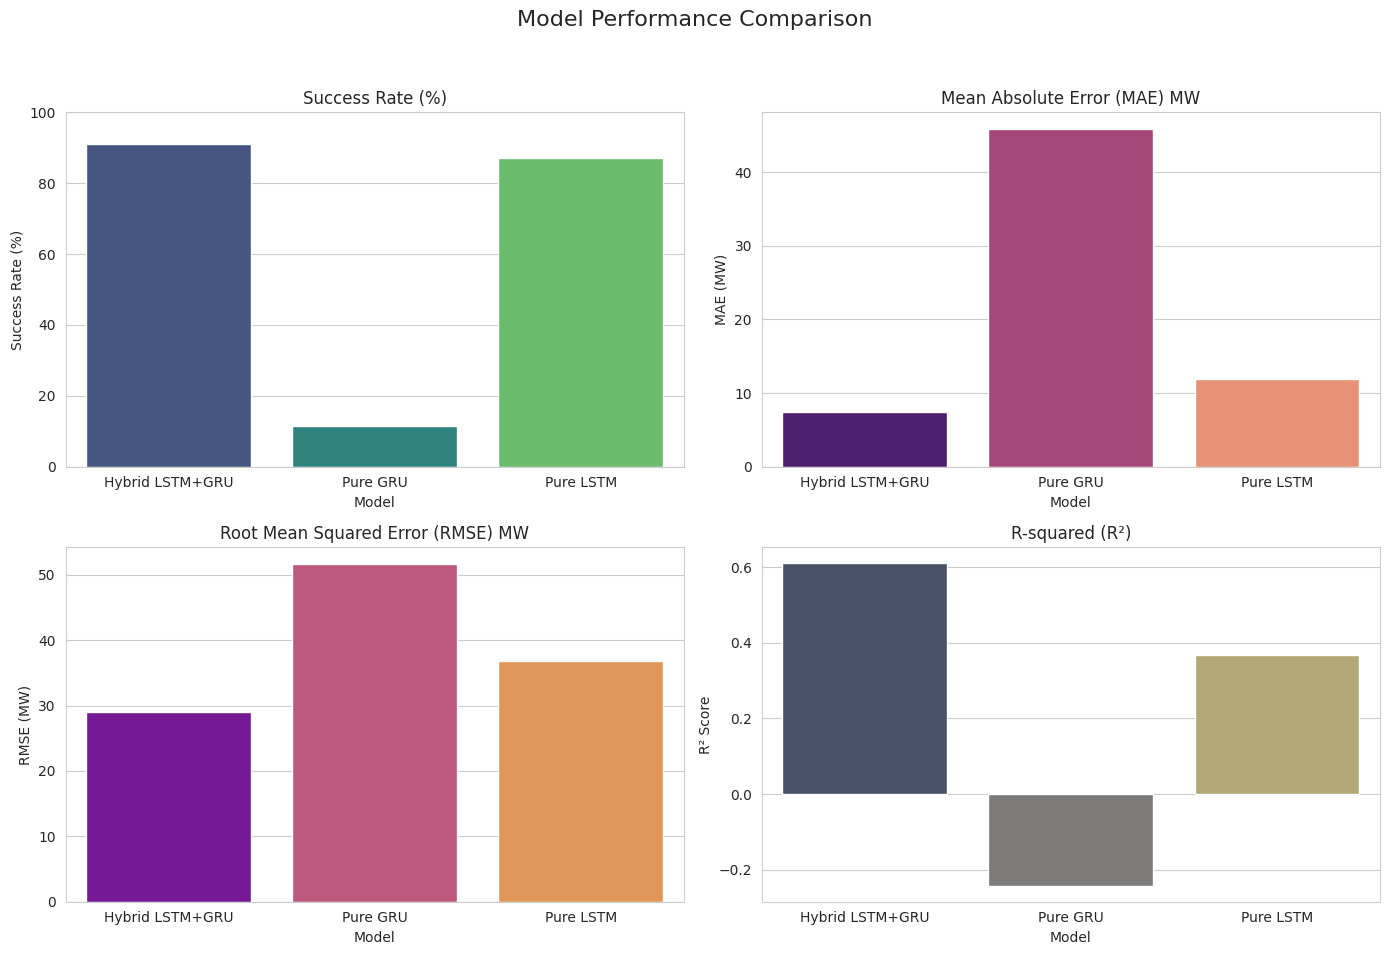

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas here as it is needed to create comparison_df

# Metrics for Hybrid GRU-LSTM Model (from latest A-yIoKi9sUNT output)
hybrid_gru_lstm_metrics = {
    'Model': 'Hybrid LSTM+GRU',
    'Success Rate': 91.08,
    'MAE': 7.49,
    'RMSE': 28.95,
    'R2': 0.6095
}

# Metrics for Pure GRU Model (from cell d1fd1cb1 output - assuming last run was this value)
pure_gru_metrics = {
    'Model': 'Pure GRU',
    'Success Rate': 11.49,
    'MAE': 45.81,
    'RMSE': 51.63,
    'R2': -0.2420
}

# Metrics for Pure LSTM Model (from cell 764470df output - assuming last run was this value)
pure_lstm_metrics = {
    'Model': 'Pure LSTM',
    'Success Rate': 87.00,
    'MAE': 11.92,
    'RMSE': 36.81,
    'R2': 0.3686
}

# Recreate comparison_df with updated metrics
comparison_df = pd.DataFrame([hybrid_gru_lstm_metrics, pure_gru_metrics, pure_lstm_metrics])

# Set style for plots
sns.set_style("whitegrid")

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot Success Rate
sns.barplot(x='Model', y='Success Rate', data=comparison_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Success Rate (%)')
axes[0, 0].set_ylabel('Success Rate (%)')
axes[0, 0].set_ylim(0, 100)

# Plot MAE
sns.barplot(x='Model', y='MAE', data=comparison_df, ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Mean Absolute Error (MAE) MW')
axes[0, 1].set_ylabel('MAE (MW)')

# Plot RMSE
sns.barplot(x='Model', y='RMSE', data=comparison_df, ax=axes[1, 0], palette='plasma')
axes[1, 0].set_title('Root Mean Squared Error (RMSE) MW')
axes[1, 0].set_ylabel('RMSE (MW)')

# Plot R2
sns.barplot(x='Model', y='R2', data=comparison_df, ax=axes[1, 1], palette='cividis')
axes[1, 1].set_title('R-squared (R²)')
axes[1, 1].set_ylabel('R² Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()